# Create RGB image from las file in Python

*Written by: Men Vuthy, 2022*

---


You can also run the code here in Google Colab. Try clicking button below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1V6ueyp7w434kFrN7ZEkLbTcS_2g7cUTE)

### Objective

*   Create RGB image from LiDAR las file
*   Save and export RGB image as `.tiff` file





### Dataset

LiDAR point cloud data visualized in LASzip tool:

<img src="image/lidar-1.png" height="250" />

### Code

**1. Create RGB image from LiDAR las file**

Install necessary modules:

```
!pip install rasterio
!pip install pylas

```



Import modules

In [1]:
import pylas
import rasterio
from rasterio.crs import CRS
from rasterio.transform import Affine
import numpy as np
from scipy.interpolate import griddata
from matplotlib.cbook import get_sample_data
from matplotlib.colors import LightSource
import matplotlib.pyplot as plt
%matplotlib inline

Move to working directory

In [2]:
cd /content/drive/MyDrive/Colab Notebooks/Porfolio/LiDAR

/content/drive/MyDrive/Colab Notebooks/Porfolio/LiDAR


Read `.las` file which is the input LiDAR point cloud data 

In [3]:
# Import input LiDAR data
inFile = pylas.read('data/data.las')

Accessing file attributes and dimensions

In [4]:
# Count total point in point cloud
print('The total point is:', inFile.header.point_count)

The total point is: 26694756


In [5]:
# List of available dimensions in the file
inFile.point_format.dimension_names

('X',
 'Y',
 'Z',
 'intensity',
 'return_number',
 'number_of_returns',
 'scan_direction_flag',
 'edge_of_flight_line',
 'classification',
 'synthetic',
 'key_point',
 'withheld',
 'scan_angle_rank',
 'user_data',
 'point_source_id',
 'red',
 'green',
 'blue')

In [6]:
# Access VLRs
VLRList = inFile.vlrs
print(VLRList)

[<GeoKeyDirectoryVlr(25 geo_keys)>, <GeoDoubleParamsVlr([c_double(0.017453292519943278), c_double(6378137.0), c_double(298.257222101), c_double(0.0), c_double(0.0), c_double(0.0), c_double(0.0), c_double(0.0), c_double(0.0), c_double(0.0), c_double(0.0), c_double(1.0), c_double(-117.00000000000001), c_double(0.0), c_double(500000.0), c_double(0.0), c_double(0.9996)])>, <GeoAsciiParamsVlr(['NAD83|NAD83 / UTM zone 11N|'])>]


To retrieve a particular vlr from the list there are 2 ways: `VLRList.get()` and `VLRList.get_by_id()`

In [7]:
# Get spatial reference system from VLRs
VLRList.get('GeoAsciiParamsVlr')[0]

<GeoAsciiParamsVlr(['NAD83|NAD83 / UTM zone 11N|'])>

From the information of srs from VLRs, we can easily determine the EPSG code by just googling it or searching from [Spatial Reference](https://spatialreference.org). As in this case, the coordinate reference of `NAD83|NAD83 / UTM zone 11N` has epsg projection of `EPSG:26911`.

To create RGB image, 5 dimensions (X, Y, red, green, and blue) will be used as input for [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html) function called `griddata(points, values, (x,y), method='linear')`. Next, let's determine all variables.

In [8]:
# Assign point list
points = list(zip(inFile.x, inFile.y))

In [9]:
# Assign band variable
red = inFile.red
green = inFile.green
blue = inFile.blue

Read the value range in each band.

In [10]:
print('datatype:', red.dtype, '-', 'min:', np.nanmin(red), '-', 'mean:', np.nanmean(red), '-', 'max:', np.nanmax(red))
print('datatype:', green.dtype, '-', 'min:', np.nanmin(green), '-', 'mean:', np.nanmean(green), '-', 'max:', np.nanmax(green))
print('datatype:', blue.dtype, '-', 'min:', np.nanmin(blue), '-', 'mean:', np.nanmean(blue), '-', 'max:', np.nanmax(blue))

datatype: uint16 - min: 0 - mean: 20182.616113966353 - max: 65535
datatype: uint16 - min: 0 - mean: 22852.409870987394 - max: 65535
datatype: uint16 - min: 0 - mean: 16258.346755557533 - max: 65535


As you can see, the value inside each band is very big which significantly slow down the runtime speed. Also, it is not possible to composite all bands when the datatype is uint16. Thus, it is better to normalize them to value range between 0.0 and 1.0. To do so, we can define a `normalize()` function and apply it to each band:

In [11]:
# Function to normalize the grid values
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = np.nanmin(array), np.nanmax(array)
    return ((array - array_min)/(array_max - array_min))

In [12]:
# Normalize the bands
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

In [13]:
print('datatype:', redn.dtype, '-', 'min:', np.nanmin(redn), '-', 'mean:', np.nanmean(redn), '-', 'max:', np.nanmax(redn))
print('datatype:', greenn.dtype, '-', 'min:', np.nanmin(greenn), '-', 'mean:', np.nanmean(greenn), '-', 'max:', np.nanmax(greenn))
print('datatype:', bluen.dtype, '-', 'min:', np.nanmin(bluen), '-', 'mean:', np.nanmean(bluen), '-', 'max:', np.nanmax(bluen))

datatype: float64 - min: 0.0 - mean: 0.3079669812156309 - max: 1.0
datatype: float64 - min: 0.0 - mean: 0.34870542261367876 - max: 1.0
datatype: float64 - min: 0.0 - mean: 0.24808646914713525 - max: 1.0


So now, we got the value of each band so much smaller which is very good for the next process.

In [14]:
# Assign grid resolution in meter
resolution = 1

# Create coord ranges over the desired raster extension
xRange = np.arange(inFile.x.min(), inFile.x.max() + resolution, resolution)
yRange = np.arange(inFile.y.min(), inFile.y.max() + resolution, resolution)

In [15]:
# Create arrays of x,y over the raster extension
gridX, gridY = np.meshgrid(xRange, yRange)

In [16]:
# Interpolate over the grid for red band
Red = griddata(points, redn, (gridX, gridY), method='linear')

In [17]:
# Interpolate over the grid for red band
Green = griddata(points, greenn, (gridX, gridY), method='linear')

In [18]:
# Interpolate over the grid for red band
Blue = griddata(points, bluen, (gridX, gridY), method='linear')

So now, red, green, and blue band are created based on points and grid. Let's check the shape of each band.

In [19]:
# Chekck the shape
print('shape of red band', Red.shape)
print('shape of green band', Green.shape)
print('shape of blue band', Blue.shape)

shape of red band (253, 618)
shape of green band (253, 618)
shape of blue band (253, 618)


Each band can be visualized as follows:

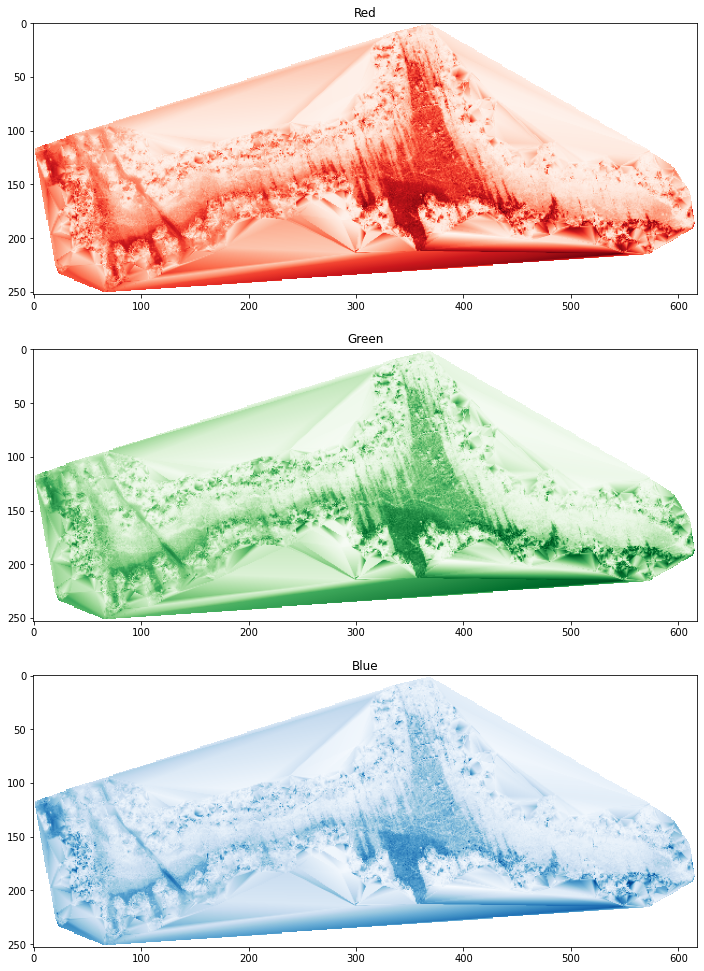

In [20]:
# Initialize subplots 
fig, axs = plt.subplots(3, 1, figsize=(30, 17), sharey=True)

# Plot Red, Green and Blue (rgb)
axs[0].imshow(Red, cmap='Reds')
axs[1].imshow(Green, cmap='Greens')
axs[2].imshow(Blue, cmap='Blues')

# Add titles
axs[0].set_title("Red")
axs[1].set_title("Green")
axs[2].set_title("Blue")

# Show plot
plt.show();

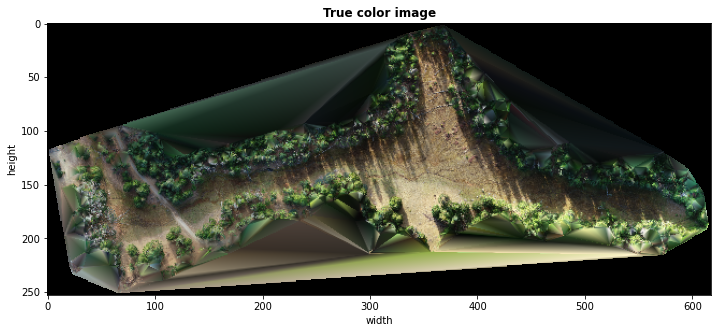

In [21]:
# Create figure
fig = plt.figure(figsize=[20, 5])

# Create RGB natural color composite
RGB = np.dstack((Red, Green, Blue))

# Let's see how our color composite looks like
plt.imshow(RGB)

# Customize plot
plt.title('True color image', fontweight='bold')
plt.xlabel('width')
plt.ylabel('height')

# Show plot
plt.show()

**2. Save and export RGB image as** `.tiff` **file**

To write numpy array to raster file, some metadata must be added such as transform, crs, shape, etc. More details are available in [rasterio module](https://rasterio.readthedocs.io/en/latest/quickstart.html#saving-raster-data).

As mentioned above, the coordinate reference system of this data is `NAD83|NAD83 / UTM zone 11N` which has epsg projection of `EPSG:26911`.

In [22]:
# Set coordinate reference system
crs = CRS.from_epsg(26911)

print(crs.data)

{'init': 'epsg:26911'}


In [23]:
# Define transform array
transform = Affine.translation(gridX[0][0]-resolution/2, gridY[0][0]-resolution/2)*Affine.scale(resolution,resolution)
transform

Affine(1.0, 0.0, 274322.467,
       0.0, 1.0, 4144468.334)

Export RGB image to raster file

In [24]:
RGB_transpose = RGB.transpose(2, 0, 1)

In [25]:
# Register metadata
out_image = rasterio.open('/content/out_rgb.tif',
                                'w',
                                driver = 'GTiff',
                                height = RGB_transpose.shape[1],
                                width = RGB_transpose.shape[2],
                                count = 3,
                                dtype = RGB_transpose.dtype,
                                crs = crs,
                                transform = transform,
                                )

# Write image
out_image.write(RGB_transpose)
out_image.close()

Finally, we can see how to create RGB image from LiDAR data in `.las` file and export it to a raster files.



---




